In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

import matplotlib.pyplot as plt

import mean_variance as mv
import risk_parity as rp

import backtest as bt

# Purpose of the Notebook

1990/1/1-2021/3/1

**All Index**

Based on our defined Musk's TSLA exposure related risks, we will use the following assets to hedge his factor risks:

- Commodity
- Nominal Bonds
- Corporate Bonds
- VIX

In [2]:
# data
idx = pd.date_range('1990/1/1','2021/3/1')

stock = pd.read_csv('data/S&P 500 Total Return Index.csv',index_col=0).iloc[2:,1]
stock = stock.astype('float')
stock.index = pd.to_datetime(stock.index)
stock = stock.pct_change().apply(lambda x: np.log(1+x))
stock = stock.loc[stock.index.isin(idx)]

commodity = pd.read_csv('data/Bloomberg Commodity Index.csv',index_col=0).iloc[2:,1]
commodity = commodity.astype('float')
commodity.index = pd.to_datetime(commodity.index)
commodity = commodity.pct_change().apply(lambda x: np.log(1+x))
commodity = commodity.loc[commodity.index.isin(idx)]

corp_bond = pd.read_csv('data/Dow Jones Corporate Bond Price Index.csv',index_col=0).iloc[2:,1]
corp_bond = corp_bond.astype('float')
corp_bond.index = pd.to_datetime(corp_bond.index)
corp_bond = corp_bond.pct_change().apply(lambda x: np.log(1+x))
corp_bond = corp_bond.loc[corp_bond.index.isin(idx)]

nom_bond = pd.read_csv('data/DGS3.csv',index_col=0)
nom_bond.loc[nom_bond['DGS3']=='.'] = 0
nom_bond = pd.to_numeric(nom_bond['DGS3'], errors = 'ignore').dropna()
nom_bond = (1+nom_bond).apply(np.log)/360/100
nom_bond.index = pd.to_datetime(nom_bond.index)
nom_bond = nom_bond.loc[nom_bond.index.isin(idx)]

vix = pd.read_csv('data/VIX.csv',index_col = 0)['Adj Close']
vix.index = pd.to_datetime(vix.index)
vix = vix.pct_change().apply(lambda x: np.log(1+x))
vix = vix.loc[vix.index.isin(idx)]

rf = pd.read_csv('data/DGS3.csv',index_col=0)
rf.loc[rf['DGS3']=='.'] = 0
rf = pd.to_numeric(rf['DGS3'], errors = 'ignore').dropna()
rf = (1+rf).apply(np.log)/360/100
rf.index = pd.to_datetime(rf.index)

# Equal Weighted

In [3]:
### Equal weight

def equal_weight(Assets = [commodity, corp_bond, nom_bond, vix]):
    asset_weights = [1/len(Assets)]*len(Assets)
    weights = []
    rtn_mat_list = []
    for i,asset in enumerate(Assets):
        weights.extend([asset_weights[i]/len(asset)] * len(asset))
        rtn_mat_list.append(pd.concat([rtn for rtn in asset],axis=1).dropna())
    weights = np.matrix(weights)
    rtn_mat = pd.concat(rtn_mat_list,axis=1).dropna()
    rtn_mat = rtn_mat.replace(float('inf'),0)
    rtn_mat = rtn_mat.replace(-float('inf'),0)
    period_rtn = rtn_mat @ weights.T
    
    return period_rtn

In [4]:
# monthly_ew = equal_weight()

In [5]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 21,
                        data_time_step_days = 1)

In [6]:
rtn_mat = pd.concat([stock,commodity, corp_bond, nom_bond, vix],axis=1).dropna()
rtn_mat.columns = ['Equity', 'Commodity', 'Corp Bonds','Nominal Bonds','VIX']

In [7]:
ew_weights = pd.DataFrame(np.ones((len(rtn_mat),5))*1/5,index = rtn_mat.index)
ew_weights.columns = ['Equity', 'Commodity', 'Corp Bonds','Nominal Bonds','VIX']

In [8]:
ew_simulator = bt.Simulator("Equal Weighted", initial_book_size=1)
ew_weights_lag = ew_simulator.add_weights_lag(ew_weights, lag=0)
tc_coeff=np.array([0.0005,0.002,0.0015,0.,0.005])
hc_coeff = np.array([0.,0.0075, 0.005, 0., 0.001])
ew_V_t_m, ew_log_ret_m, ew_turnover_df_m = ew_simulator.cal_pnl(ew_weights_lag, 
                                                          rtn_mat, 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


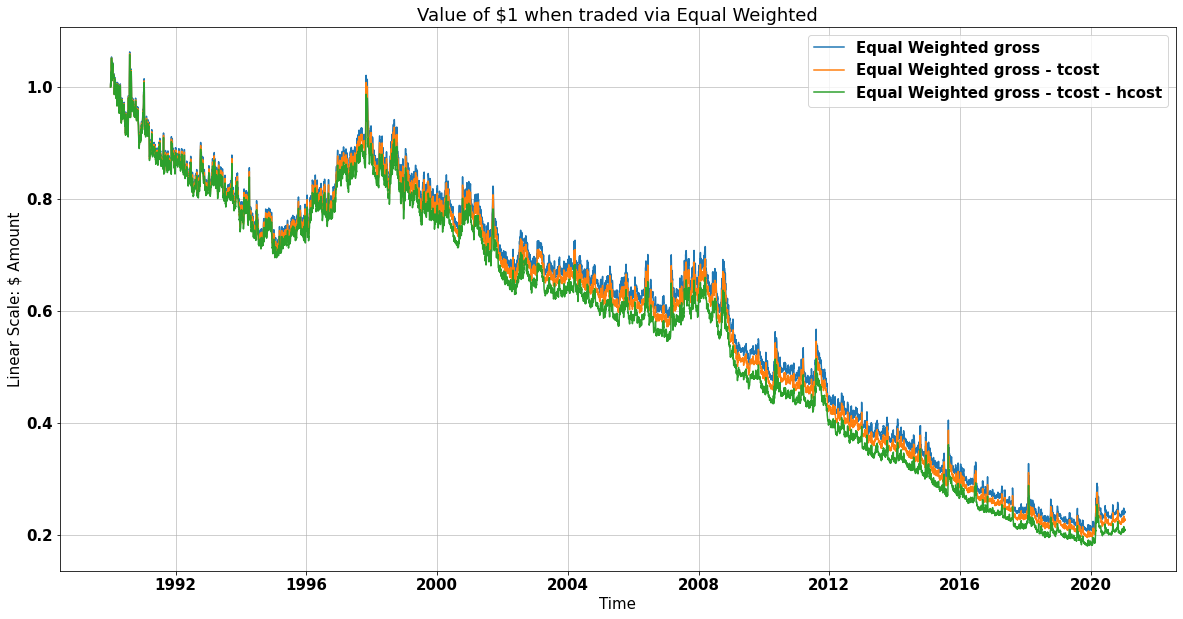

In [9]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=ew_V_t_m, 
                    strategy_name="Equal Weighted", 
                    initial_book_size=1, 
                    scale= 'linear')

In [10]:
rtn_mat = rtn_mat.join(rf.rename('rf_ret'))

In [11]:
indicator = bt.Indicator()
ew_stats = indicator.agg_stats(ew_log_ret_m, 
                               rtn_mat, 
                               ew_V_t_m,
                               ew_turnover_df_m)
visualizer.show_stats(ew_stats)

                                                            Mean Annualized Performance Statistics
+--------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                      |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|--------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Equal Weighted gross                 |          -0.27 |         -4.64 |            20.16 |          66.76 |       0.06 |       0.06 |             -80.57 |
| Equal Weighted gross - tcost         |          -0.28 |         -4.83 |            20.16 |          66.76 |       0.06 |       0.06 |             -81.54 |
| Equal Weighted gross - tcost - hcost |          -0.29 |         -5.1  |            20.16 |          66.81 |       

# Minimum Variance

In [12]:
mv_weights = mv.min_var_multi(rtn_mat.iloc[:,:-1])

100%|██████████| 7682/7682 [00:08<00:00, 868.40it/s]


In [13]:
mv_simulator = bt.Simulator("Min-Var Weighted", initial_book_size=1)
mv_weights_lag = mv_simulator.add_weights_lag(mv_weights, lag=0)
tc_coeff=np.array([0.0005,0.002,0.0015,0.,0.005])
hc_coeff = np.array([0.,0.0075, 0.005, 0., 0.001])
mv_V_t_m, mv_log_ret_m, mv_turnover_df_m = mv_simulator.cal_pnl(mv_weights_lag, 
                                                          rtn_mat.loc[mv_weights.index].iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

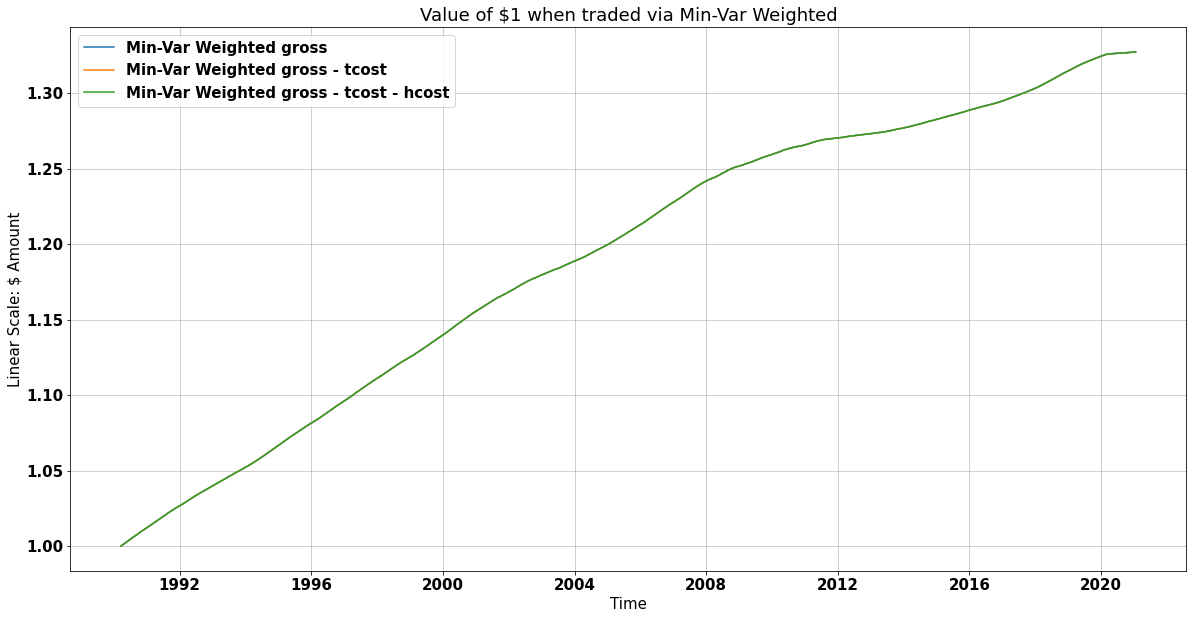

In [14]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=mv_V_t_m, 
                    strategy_name="Min-Var Weighted", 
                    initial_book_size=1, 
                    scale= 'linear')

In [15]:
indicator = bt.Indicator()
mv_stats = indicator.agg_stats(mv_log_ret_m, 
                               rtn_mat.loc[mv_weights.index], 
                               mv_V_t_m,
                               mv_turnover_df_m)
visualizer.show_stats(mv_stats)

                                                            Mean Annualized Performance Statistics
+----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                        |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|----------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Min-Var Weighted gross                 |          -0.16 |          0.93 |             0.03 |           3.57 |      -0.02 |         -0 |                 -0 |
| Min-Var Weighted gross - tcost         |          -0.33 |          0.93 |             0.03 |           3.57 |      -0.02 |         -0 |                 -0 |
| Min-Var Weighted gross - tcost - hcost |          -0.36 |          0.93 |             0.03 |           3

# Risk Parity

In [16]:
rp_model = rp.RiskParity(1,list(rtn_mat.iloc[:,:-1].columns),rtn_mat.iloc[:,:-1],252,10,360)

In [17]:
trade, trade_pct, rp_weights, returns = rp_model.get_flow()

/home/jupyter/factor_timing/risk_parity.py:47: RuntimeWarning: divide by zero encountered in true_divide
  trade_weight = trade[i - 1] / (NAV[i] * target_weights[i])


In [18]:
cols = [c for c in rp_weights if 'target' in c]
rp_weights = rp_weights[cols]
rp_weights.columns = rtn_mat.columns[:-1]
rp_weights = rp_weights.divide(rp_weights.sum(axis=1),axis=0)

In [19]:
rp_simulator = bt.Simulator("Risk Parity Weighted", initial_book_size=1)
rp_weights_lag = rp_simulator.add_weights_lag(rp_weights, lag=0)
tc_coeff=np.array([0.0005,0.002,0.0015,0.,0.005])
hc_coeff = np.array([0.,0.0075, 0.005, 0., 0.001])
rp_V_t_m, rp_log_ret_m, rp_turnover_df_m = rp_simulator.cal_pnl(rp_weights_lag, 
                                                          rtn_mat.loc[rp_weights.index].iloc[:,:-1], 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

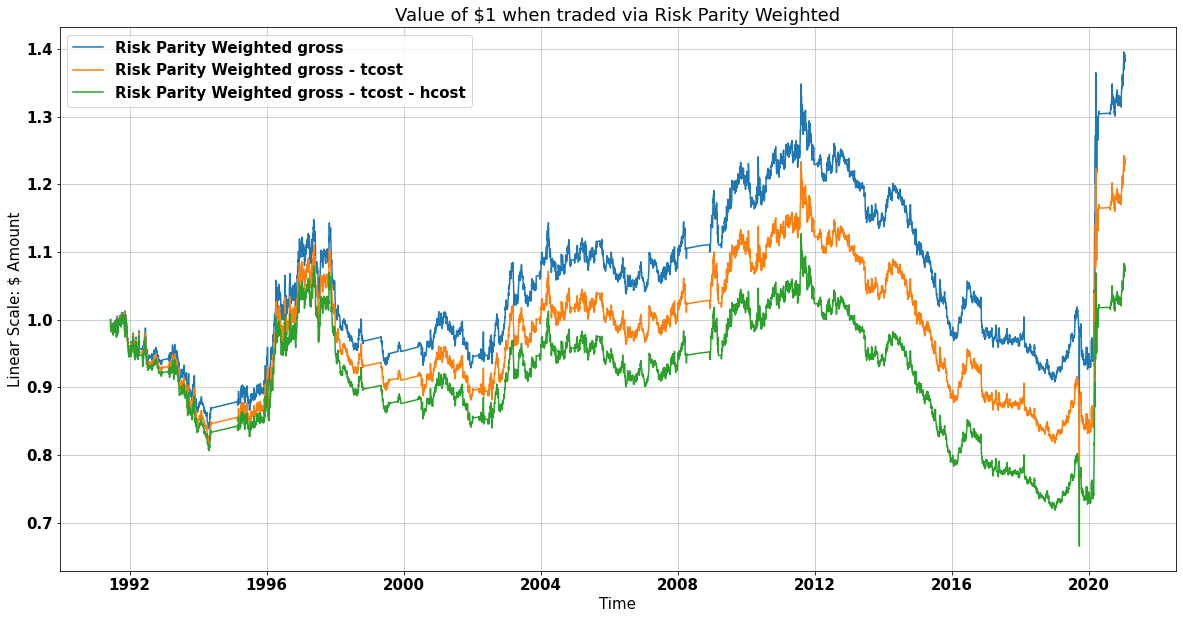

In [20]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=rp_V_t_m, 
                    strategy_name="Risk Parity Weighted", 
                    initial_book_size=1, 
                    scale= 'linear')

In [21]:
indicator = bt.Indicator()
rp_stats = indicator.agg_stats(rp_log_ret_m, 
                               rtn_mat.loc[rp_weights.index], 
                               rp_V_t_m,
                               rp_turnover_df_m)
visualizer.show_stats(rp_stats)

                                                            Mean Annualized Performance Statistics
+--------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                            |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|--------------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Risk Parity Weighted gross                 |           0.02 |          1.11 |             9.04 |         331.51 |       0.11 |       0.62 |             -37.31 |
| Risk Parity Weighted gross - tcost         |          -0.02 |          0.71 |             9.04 |         331.51 |       0.11 |       0.62 |             -38.41 |
| Risk Parity Weighted gross - tcost - hcost |          -0.07 |          0.24 |       